<a href="https://colab.research.google.com/github/abrarelidrisi/MRI-Segmentation/blob/main/Final_2D_MRI_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Task 1 and 2 of the MRI Segmentation task:**
## Important note: In this notebook, I'm showcasing the masks, the final segmented slices and their metrics. Feel free to uncomment the visualization commands to provide an illustration. If you uncomment and then run the final loop, it will show you all the steps from beginning to the final segmented image. In addition, I have provided **another notebook** that showcase **EACH STEP VISUALIZED** for any chosen slice.

In [1]:
#Importing important libraries and loading our dataset (containing of MRI scans and the ground truth (Segmented)images

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.io import loadmat
import sys
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, binary_dilation
from skimage.feature import canny
import scipy.ndimage as ndi
from sklearn.cluster import KMeans

In [2]:
#Since I'll be using edge detection algorithms like Canny later on, It's better to normalize our data so the algorithms can perform better and not put muc count to outliers
def normalizing(T1):
  T1_normalized = (T1 - np.min(T1)) / (np.max(T1) - np.min(T1))
  slice_normalized = T1_normalized[...,slice_idx]
  return slice_normalized


In [3]:
#We now start the segmentation process, beginning with smotthing using Gaussian filter
def smoothing(slice_normalized):
  # Apply Gaussian smoothing
  slice_smoothed = cv2.GaussianBlur(slice_normalized, (5, 5), 0)

  #Uncomment to visualize the preprocessed slice
  # plt.imshow(slice_smoothed, cmap='gray')
  # plt.title("Preprocessed (smoothed) Slice")
  # plt.show()
  return slice_smoothed


In [4]:
# Apply Otsu's thresholding
def otsu_thresholding(slice_smoothed):
  _, thresholded = cv2.threshold((slice_smoothed * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Visualize thresholded result
  # plt.imshow(thresholded, cmap='gray')
  # plt.title("Otsu Thresholding")
  # plt.show()
  return thresholded

In [5]:
# Showcasing the outcome of applying otsu on our smoothed slice
def showcase_thresholded(thresholded, slice_smoothed):
  thresholded_img = thresholded * slice_smoothed
  # plt.imshow(thresholded_img, cmap='gray')
  # plt.axis('off')
  # plt.title('Thresholded')
  # plt.show()
  return thresholded_img

In [6]:
#Applying Canny Edge detection to mainly handle the internal structure. We later note that using tools to fill holes and remove small objects has impressively increased our segmentation accuracy
def applying_canny(thresholded_img):
  edges = canny(thresholded_img, sigma=2)
  # Dilate the edges
  edges = ndi.binary_dilation(edges)

  # Fill holes in the edges
  edges = ndi.binary_fill_holes(edges)

  # remove small objects
  edges = remove_small_objects(edges, min_size=100)
  # Plot the edges
  # plt.imshow(edges, cmap='gray')
  # plt.axis('off')
  # plt.title('Canny')
  # plt.show()
  return edges

In [7]:
#Showcasing the effect of applying Canny edge detection to our image
def showcasing_canny(slice_normalized, edges):
  img_thresholded = slice_normalized * edges
  # plt.imshow(img_thresholded)
  # plt.axis('off')
  # plt.title('Masked Edges')
  # plt.show()
  return img_thresholded

In [8]:
#Define k-means segmentation so we can apply it to the image
def kmeans_segmentation(image, n_clusters=6):
    # Reshape the image to a 2D array
    X = image.reshape(-1, 1)

    # Fit KMeans to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    # Predict the labels for the data
    labels = kmeans.fit_predict(X)

    # Reshape the labels to the original image shape
    labels = labels.reshape(image.shape)

    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_

    # Order the centroids and return the indices
    order = np.argsort(centroids, axis=0)

    return labels, order

In [9]:
#Creating a temporal_mask dictionary so we can ensure efficient mapping
def temporal_mask_creation(cluster_labels, order):
  temporal_masks = {}
  temporal_masks["0"] = (cluster_labels == order[0]).astype(int)
  temporal_masks["1"] = (cluster_labels == order[1]).astype(int)
  temporal_masks["2"] = (cluster_labels == order[2]).astype(int)
  temporal_masks["3"] = (cluster_labels == order[3]).astype(int)
  temporal_masks["4"] = (cluster_labels == order[4]).astype(int)
  temporal_masks["5"] = (cluster_labels == order[5]).astype(int)
  return temporal_masks

In [10]:
#Defining functions to help in plotting our masks, as well as cobining the masks to give our final segmented output
def plot_masks(temporal_masks, rows=1, cols=2, slice_id = None):

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    fig.suptitle('Temporal Masks')

    flatten_axes = axes.flat
    for ax, (key, mask) in zip(flatten_axes, temporal_masks.items()):
        if slice_id is not None:
            mask = mask[:,:,slice_id]
        ax.imshow(mask, cmap='gray')
        ax.set_title(f'Mask: {key}')
        ax.axis('off')

    plt.tight_layout()
    # plt.show()

def temporal_masks2final_segmented_mask(temporal_masks, labels = range(6), slice_id = None):
    if slice_id is not None:
        segmented_labels = np.zeros_like(temporal_masks["0"][:,:,0])
    else:
        segmented_labels = np.zeros_like(temporal_masks["0"])

    # Accumulate all the temporal masks in the segmented_labels
    for label in labels:
        mask = temporal_masks[str(label)]
        if slice_id is not None:
            mask = mask[:,:,slice_id]
        segmented_labels[mask == 1] = label

    return segmented_labels

In [11]:
# Uncomment to showcase the masks
# plot_masks(temporal_masks, rows=2, cols=4)

In [30]:
#function to showcase our final segmented image
def showcase_segmented_image(temporal_masks):
  segmented_img = temporal_masks2final_segmented_mask(temporal_masks)

  # Plot the final segmented image
  # plt.imshow(segmented_img)
  # plt.title('Segmented Output')
  # plt.colorbar(ticks=range(6), label="Labels (0-5)")
  # plt.show()
  return segmented_img

In [13]:
#Defining our Dice metrics
def dice_coefficient(pred, truth):
    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format
    intersection = np.sum(pred * truth)
    return 2 * intersection / (np.sum(pred) + np.sum(truth))
# dice_score = dice_coefficient(segmented_img, ground_truth)
# print(f"Dice Coefficient: {dice_score:.3f}")

In [14]:
#Defining our Jaccard metrics
def jaccard_index(pred, truth):
    pred = pred > 0
    truth = truth > 0
    intersection = np.sum(pred * truth)
    union = np.sum(pred + truth) - intersection
    return intersection / union
# # jaccard_score = jaccard_index(segmented_img, ground_truth)
# # print(f"Jaccard Index: {jaccard_score:.3f}")

In [15]:
#Defining our accuracy metrics
def pixel_accuracy(pred, truth):

    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format

    correct = np.sum(pred == truth)  # Count matching pixels
    total = truth.size  # Total number of pixels
    return correct / total

# accuracy_score = pixel_accuracy(segmented_img, ground_truth)
# print(f"Pixel Accuracy: {accuracy_score:.3f}")

In [16]:
#Showcasing the performance of our segmentation algoirthm vs. the ground truth
def compare_label_distributions(ground_truth, prediction, num_classes):

    # Count label occurrences in ground truth
    gt_labels, gt_counts = np.unique(ground_truth, return_counts=True)
    gt_distribution = np.zeros(num_classes)
    gt_distribution[gt_labels] = gt_counts

    # Count label occurrences in prediction
    pred_labels, pred_counts = np.unique(prediction, return_counts=True)
    pred_distribution = np.zeros(num_classes)
    pred_distribution[pred_labels] = pred_counts

    # Normalize to percentage if needed
    gt_percentage = (gt_distribution / np.sum(gt_distribution)) * 100
    pred_percentage = (pred_distribution / np.sum(pred_distribution)) * 100

    # Plot the distributions
    labels = [f"Class {i}" for i in range(num_classes)]
    x = np.arange(num_classes)

    plt.figure(figsize=(10, 6))

    # Bar plot
    plt.bar(x - 0.2, gt_percentage, width=0.4, label='Ground Truth (%)', color='blue')
    plt.bar(x + 0.2, pred_percentage, width=0.4, label='Prediction (%)', color='orange')

    # Add labels, legend, and title
    plt.xticks(x, labels)
    plt.xlabel("Class Labels")
    plt.ylabel("Percentage of Pixels (%)")
    plt.title("Label Distribution: Ground Truth vs Prediction")
    plt.legend()
    plt.tight_layout()
    plt.show()


num_classes = 6
# compare_label_distributions(ground_truth, segmented_img, num_classes)

In [39]:
#Defining a segmentation function that applies the whol steps
def full_segmentation(slice_idx):
  slice_data = T1[..., slice_idx]
  ground_truth = label[..., slice_idx]

  slice_normalized = normalizing(T1)
  slice_smoothed = smoothing(slice_normalized)
  thresholded = otsu_thresholding(slice_smoothed)
  thresholded_img = showcase_thresholded(thresholded, slice_smoothed)
  edges = applying_canny(thresholded_img)
  img_thresholded = showcasing_canny(slice_normalized, edges)
  cluster_labels, order = kmeans_segmentation(img_thresholded, n_clusters=6)
  temporal_masks = temporal_mask_creation(cluster_labels, order)
  segmented_img = showcase_segmented_image(temporal_masks)
  dice_score = dice_coefficient(segmented_img, ground_truth)
  jaccard_score = jaccard_index(segmented_img, ground_truth)
  accuracy_score = pixel_accuracy(segmented_img, ground_truth)
  return temporal_masks, segmented_img, dice_score, jaccard_score, accuracy_score

In [26]:
# Load data
data = loadmat('Brain.mat')
T1 = data['T1']
label = data['label']

Slice 0
Dice Coefficient: 0.976
Jaccard Index: 19.910
Pixel Accuracy: 0.965


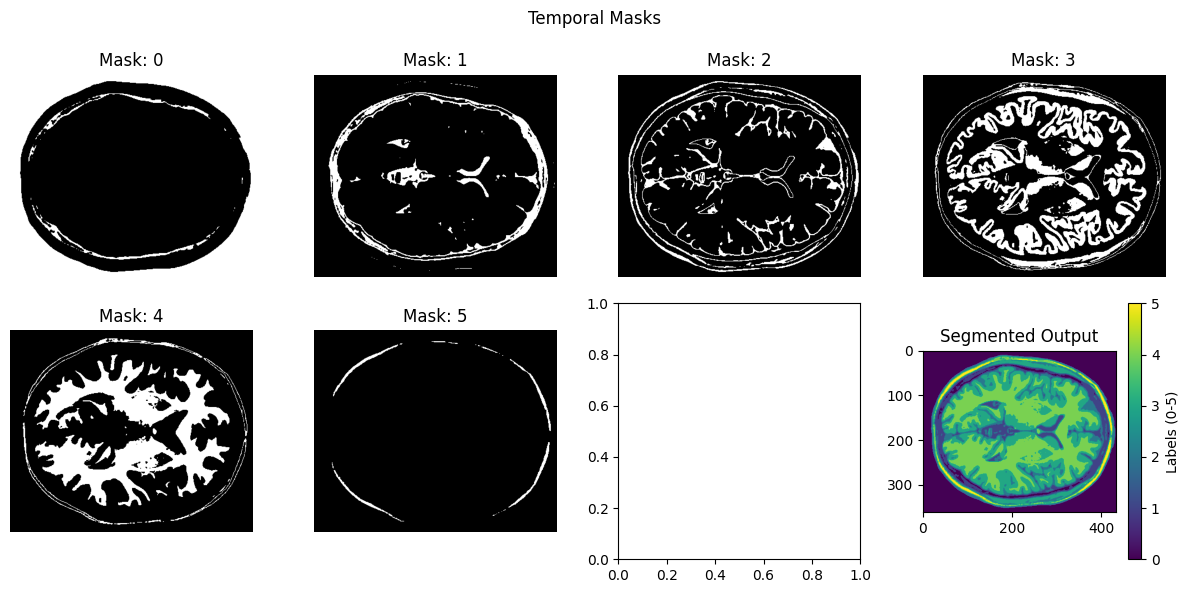

---------------------------------
Slice 1
Dice Coefficient: 0.973
Jaccard Index: 18.302
Pixel Accuracy: 0.962


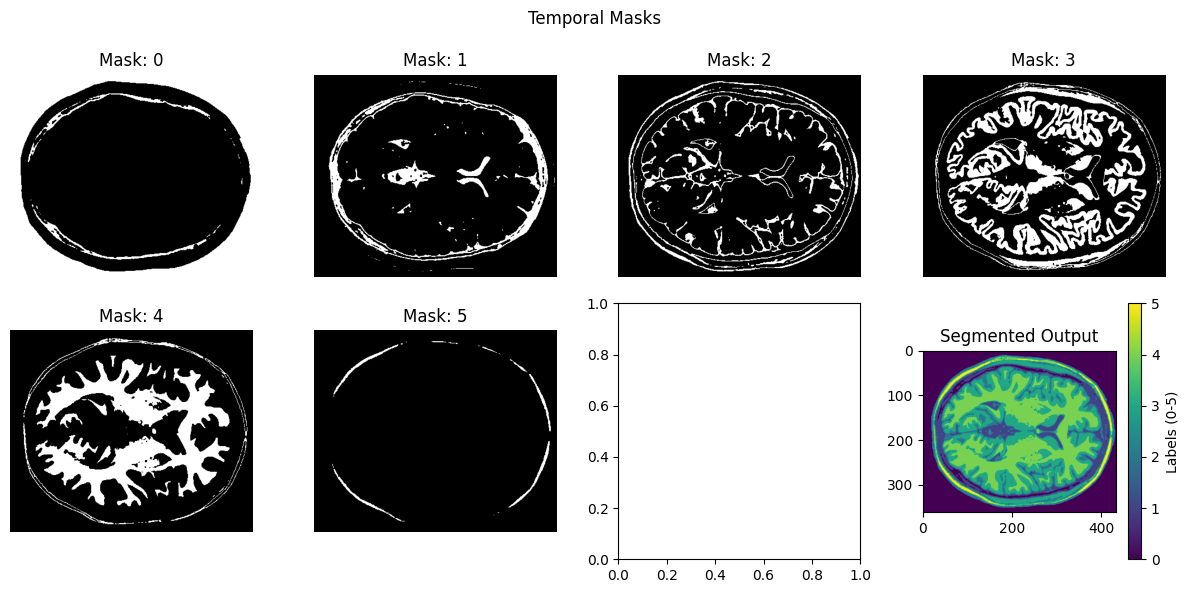

---------------------------------
Slice 2
Dice Coefficient: 0.979
Jaccard Index: 23.079
Pixel Accuracy: 0.970


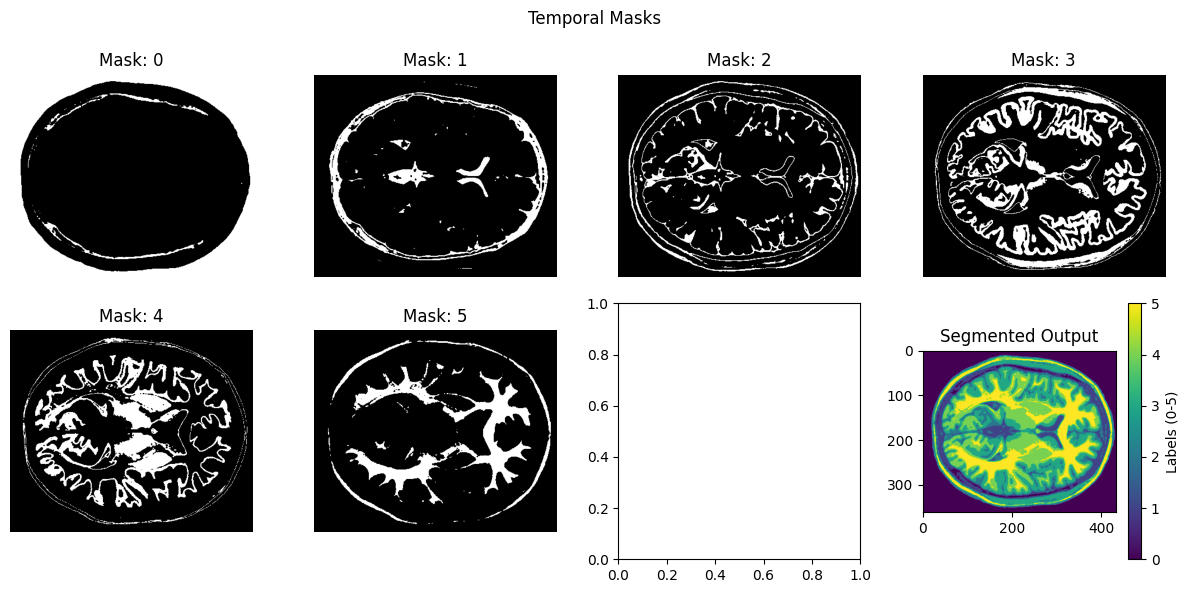

---------------------------------
Slice 3
Dice Coefficient: 0.977
Jaccard Index: 21.031
Pixel Accuracy: 0.967


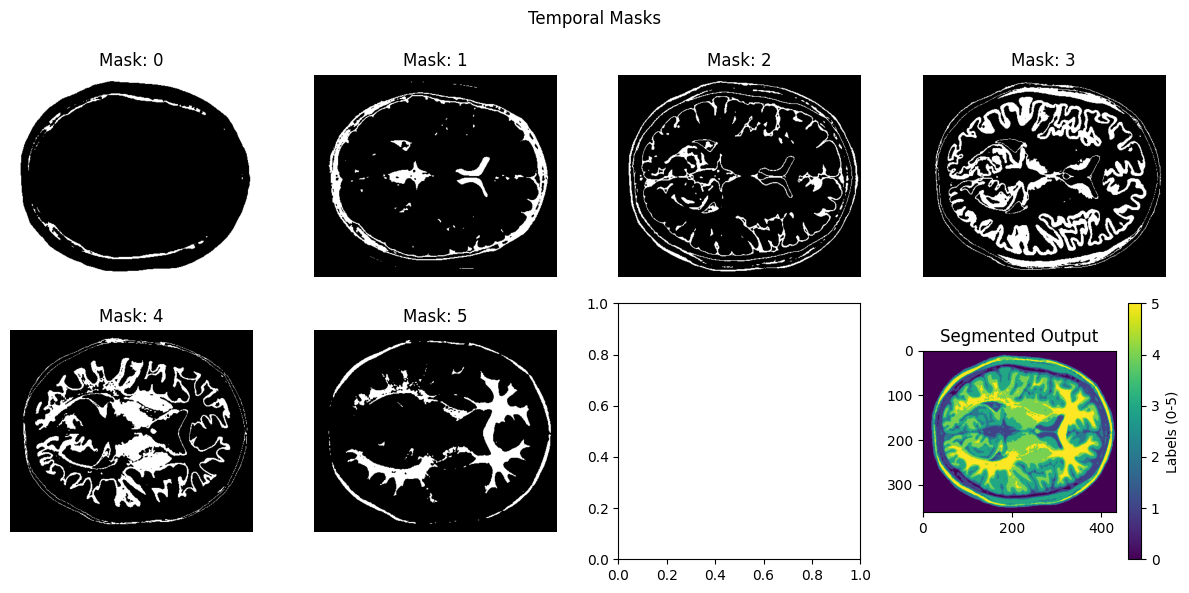

---------------------------------
Slice 4
Dice Coefficient: 0.978
Jaccard Index: 22.121
Pixel Accuracy: 0.968


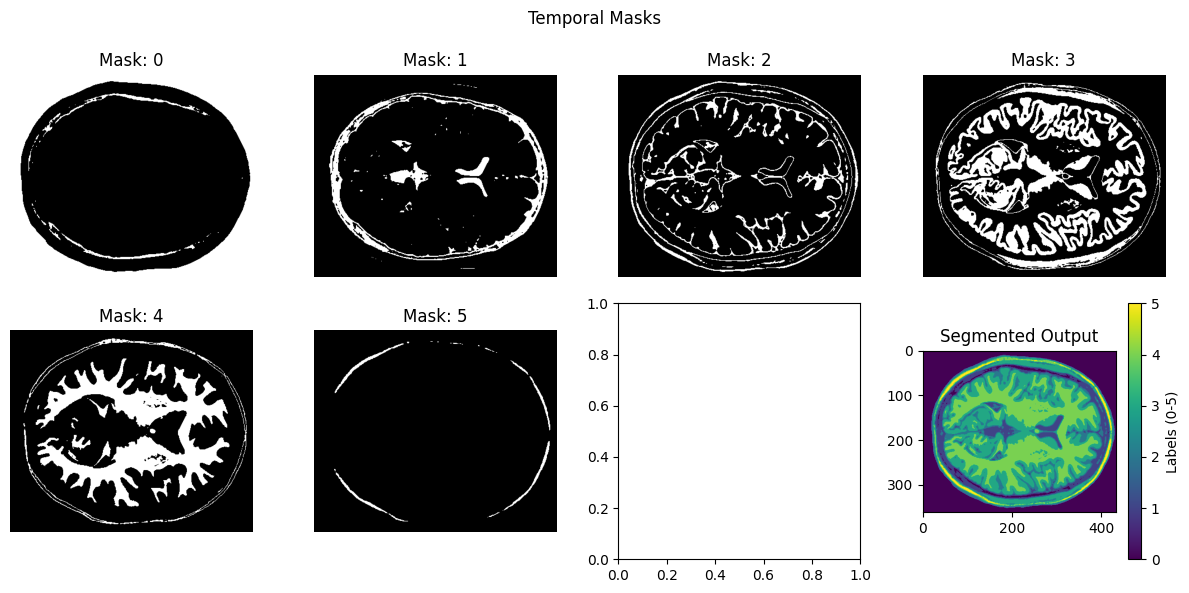

---------------------------------
Slice 5
Dice Coefficient: 0.976
Jaccard Index: 20.300
Pixel Accuracy: 0.966


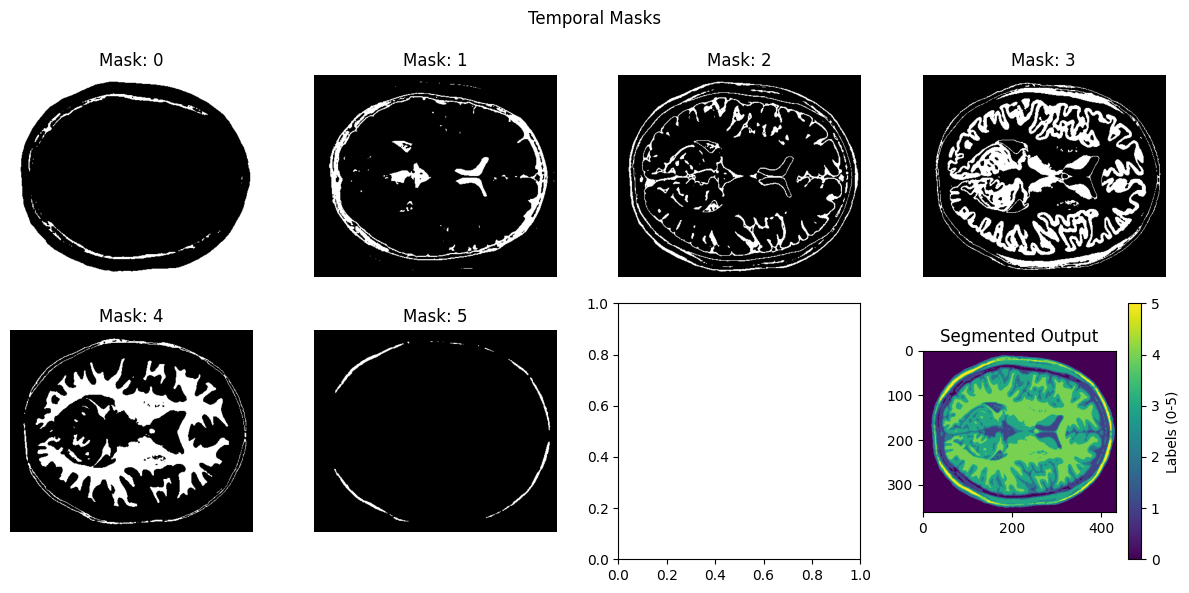

---------------------------------
Slice 6
Dice Coefficient: 0.978
Jaccard Index: 22.435
Pixel Accuracy: 0.969


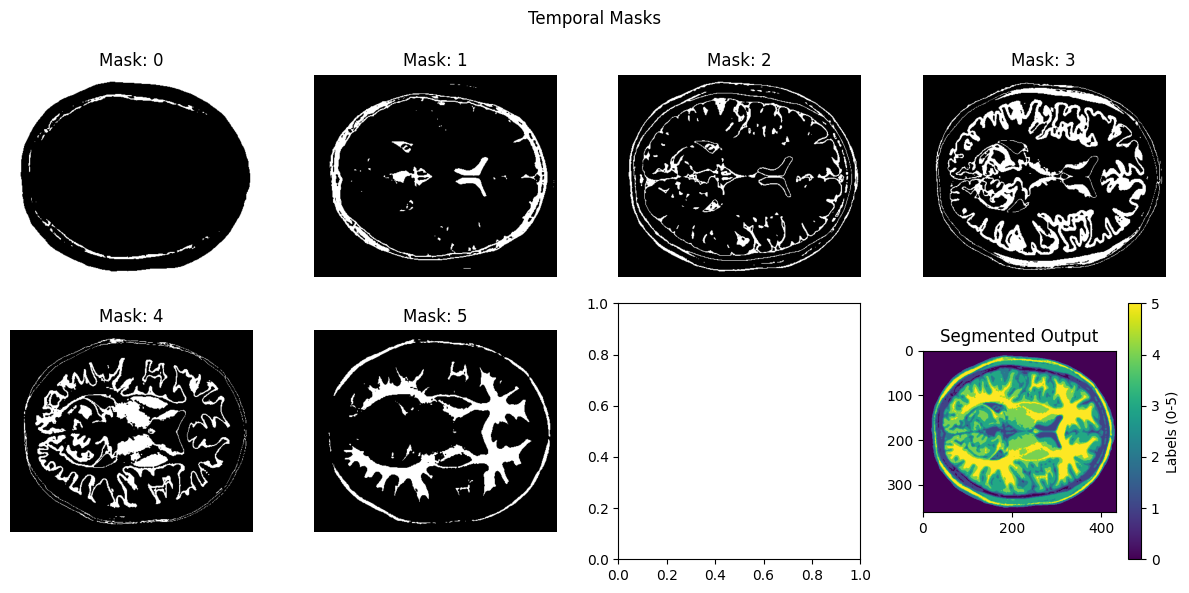

---------------------------------
Slice 7
Dice Coefficient: 0.972
Jaccard Index: 17.350
Pixel Accuracy: 0.961


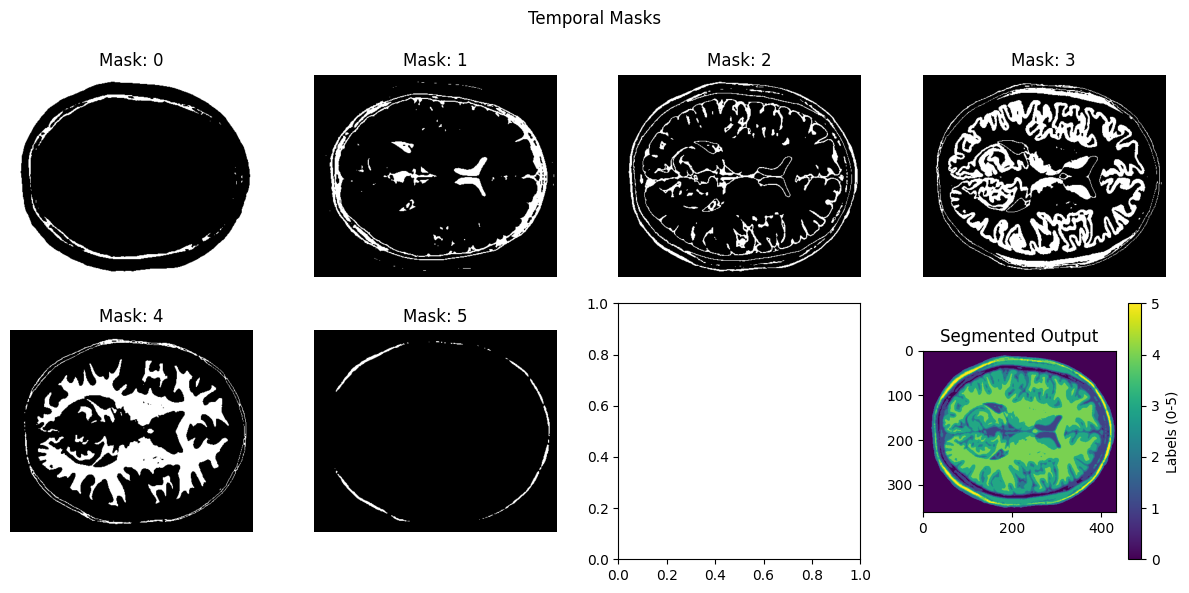

---------------------------------
Slice 8
Dice Coefficient: 0.975
Jaccard Index: 19.459
Pixel Accuracy: 0.965


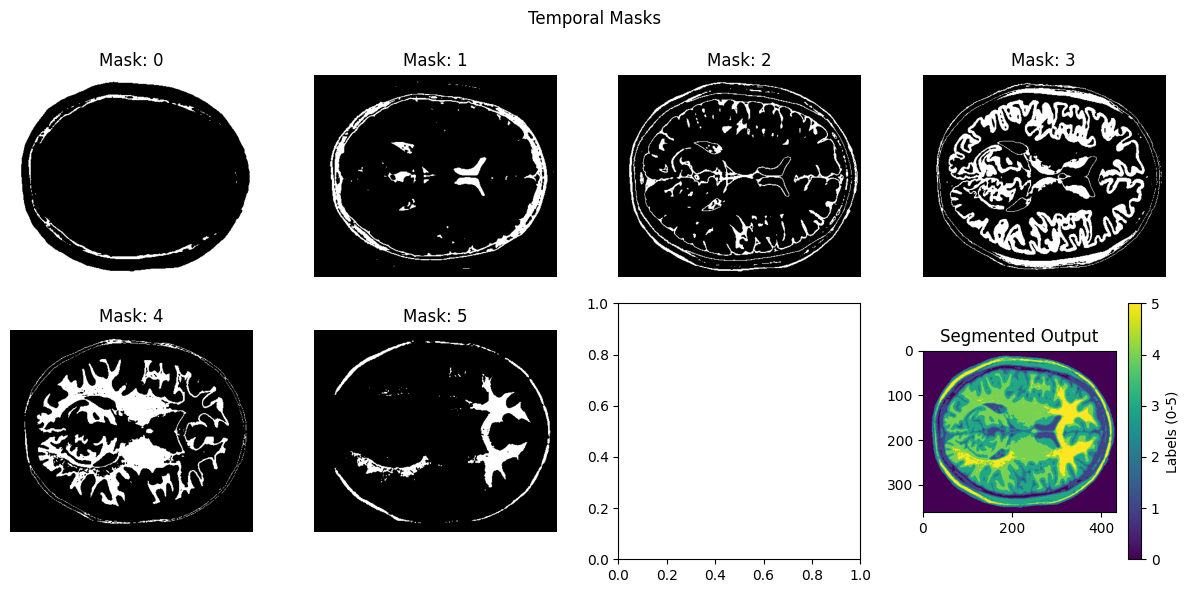

---------------------------------
Slice 9
Dice Coefficient: 0.976
Jaccard Index: 20.469
Pixel Accuracy: 0.966


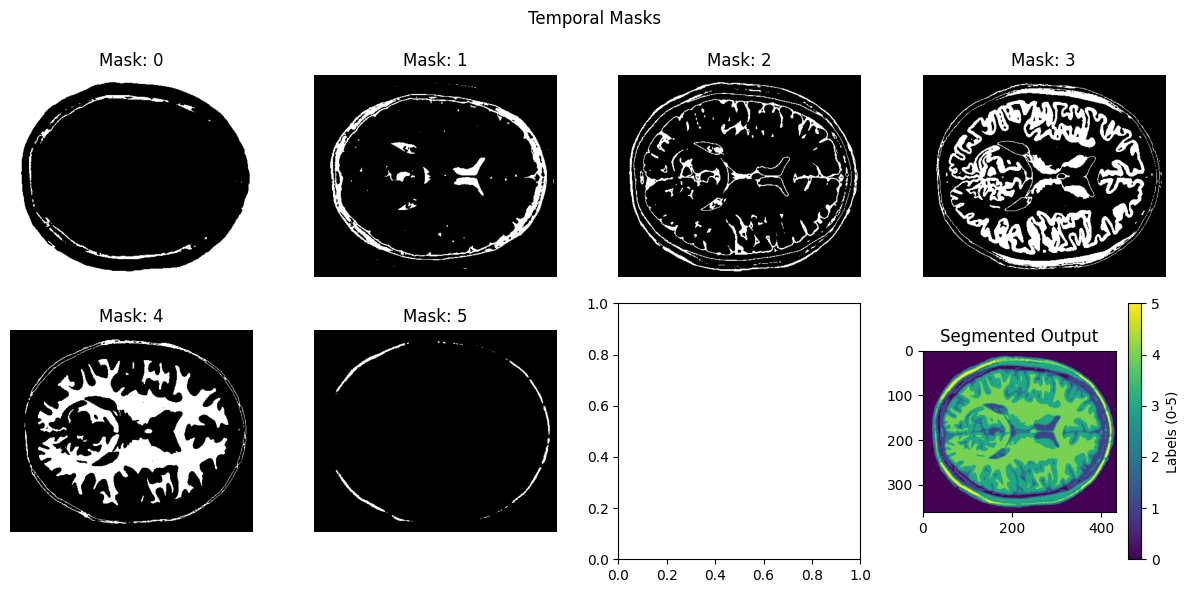

---------------------------------


In [40]:
#Loop throigh ths slices, showcase each final segmented slice and its corrresponding score
for slice_idx in range(T1.shape[2]):
  temporal_masks, segmented_img, dice_score, jaccard_score, accuracy_score = full_segmentation(slice_idx)
  print(f"Slice {slice_idx}")
  print(f"Dice Coefficient: {dice_score:.3f}")
  print(f"Jaccard Index: {jaccard_score:.3f}")
  print(f"Pixel Accuracy: {accuracy_score:.3f}")
  plot_masks(temporal_masks, rows=2, cols=4)
  plt.imshow(segmented_img)
  plt.title('Segmented Output')
  plt.colorbar(ticks=range(6), label="Labels (0-5)")
  plt.show()
  print("---------------------------------")

In [48]:
import pandas as pd

def display_metrics_table(num_slices):

    # Initializing an empty list to store metrics for all slices
    metrics = []

    # Loop through all slice indices
    for slice_idx in range(num_slices):
        # Call the full_segmentation function for the current slice
        temporal_masks, segmented_img, dice_score, jaccard_score, accuracy_score = full_segmentation(slice_idx)

        # Store metrics for the current slice in a dictionary
        metrics.append({
            "Slice Index": slice_idx,
            "Dice Coefficient": dice_score,
            "Jaccard Index": jaccard_score,
            "Pixel Accuracy": accuracy_score
        })

    # Creating a Pandas DataFrame from the metrics list
    metrics_df = pd.DataFrame(metrics)

    # Display the table
    print("\nSegmentation Metrics for All Slices:\n")
    print(metrics_df)
    metrics_df.to_csv("segmentation_metrics.csv", index=False)

num_slices = T1.shape[2]
display_metrics_table(num_slices)


Segmentation Metrics for All Slices:

   Slice Index  Dice Coefficient  Jaccard Index  Pixel Accuracy
0            0          0.965920      14.171440        0.951549
1            1          0.966852      14.583885        0.952918
2            2          0.967846      15.050084        0.954375
3            3          0.968623      15.435398        0.955515
4            4          0.969624      15.960349        0.956979
5            5          0.970737      16.586562        0.958602
6            6          0.971957      17.329960        0.960378
7            7          0.973361      18.269263        0.962414
8            8          0.974846      19.377762        0.964566
9            9          0.976155      20.468691        0.966456
